# Ready-to-use Bio Sequencing Regression MVP

**Goal**: Train a simple regression model on ESM1b embeddings of a {sequence, readout} dataset.


Do you have a dataset of {sequence, readout} pairs? Are your sequences full of 
A, C, T, and G? 

Use this script to run a baseline regression model on it. Replace the stuff in 
"Section 1" with your own CSV import, then run the rest. 

**Steps**: 
 1. Load the data. 
 2. Run data through ESM model. 
 3. Cache representations to disk (save compute). 
 4. [Simplification] Compute the mean token representation for each sequence -- used as feature vector for the next step. 
 5. [Simplification] Make a train/validation/test set, train a regularized linear regression model. 
 6. View the train/test performance. 

In [1]:
# Import box 
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm 

import torch
import esm

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PLOT = False # do we want to plot intermediate figures? 

## 1: Load your sequence-readout dataset

I'm loading in some gene regulation data from Kevin (who in turn got it from our good friend [Bob Phillips](https://www.bbe.caltech.edu/people/rob-phillips)).

In [3]:
data_path = 'RegSeq_100_genes_data/'
fname = 'araCAnaerodataset_alldone_with_large'
df = pd.read_fwf(os.path.join(data_path, fname))

# rename column 'ct' -> 'count' 
df = df.rename(columns={'ct_0':'dna_count'})
df = df.rename(columns={'ct_1':'rna_count'})
df.head(3)

,ct,dna_count,rna_count,seq
0,1.0,1.0,0.0,AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGG...
1,1.0,1.0,0.0,AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGG...
2,1.0,1.0,0.0,AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGG...


In [4]:
# plot scatter plot of dna_count, rna_count 
if PLOT: 
    plt.scatter(df['dna_count'], df['rna_count'])
    plt.xlabel('DNA count')
    plt.ylabel('RNA count')
    plt.title('DNA count vs RNA count')
    plt.show()


In [5]:
# scatter of ct, dna_count 
if PLOT: 
    plt.scatter(df['ct'], df['dna_count'])
    plt.xlabel('ct')
    plt.ylabel('DNA count')
    plt.title('ct vs DNA count')
    plt.show()

Let's remove the rows with zero DNA count. 

In [6]:
df = df[df['dna_count'] > 0]
# reset index

# new histogram
if PLOT: 
    df['dna_count'].hist(bins=100)
    # title
    plt.title(f'Histogram of DNA counts (total = {len(df)})')
    # x-axis label
    plt.xlabel('DNA count')
    # y-axis label
    plt.ylabel('Frequency')

Apparently, the expression level is the ratio of RNA count to DNA count. 

Let's add an "expression" column for that. 

In [7]:
df['expression'] = df['rna_count'] / df['dna_count']
df['log_expression'] = np.log(df['expression']+1e-9)


if PLOT: 
    df['expression'].hist(bins=100)

In [8]:
# scatter plot of expression vs. ct
if PLOT: 
    plt.scatter(df['ct'], df['expression'])
    plt.xlabel('ct')
    plt.ylabel('Expression')
    plt.title('Expression vs ct')
    plt.show()


Let's cache the csv to disk for future reference -- e.g., writing experiment 
scripts to run at scale. 

In [9]:
# reset index 
df = df.reset_index(drop=True)

# make the cache dir if it doesn't already exist 
if not os.path.exists('cache'):
    os.makedirs('cache')

# save the filtered dataframe to disk 
save_name = f'cache/{fname}_filtered_{len(df)}.csv'
print("Saving to ", save_name, "...")
df.to_csv(save_name, index=False)
print("Done!")

Saving to  cache/araCAnaerodataset_alldone_with_large_filtered_5812.csv ...
Done!


In [10]:
df.head(3)

,ct,dna_count,rna_count,seq,expression,log_expression
0,1.0,1.0,0.0,AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGG...,0.0,-20.723266
1,1.0,1.0,0.0,AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGG...,0.0,-20.723266
2,1.0,1.0,0.0,AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGG...,0.0,-20.723266


## 2: Run the Sequences thru ESM Model

At this point, the dataframe is formatted with a 'sequence' column.


NOTE: Get rid of the `model.to('cuda')` line if you don't have a CUDA GPU.

Without a GPU, this takes ~1 hour to run on my Macbook air. It takes about 1 
minute to run on an A100 GPU. 

See the [ESM](https://github.com/facebookresearch/esm) Github to see if the 
esm2_t33_650M_UR50D model will fit on your GPU. 

In [78]:
# %%  Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

model.to(DEVICE)

print("Model device: ", next(model.parameters()).device)

Model device:  cuda:0


In [86]:
# Format the data for use in ESM 
# iterate thru rows of df 
data_list = []

for index, row in df.iterrows():
    # get dna sequence 
    seq = row['seq']
    # convert to uppercase 
    seq = seq.upper()
    tup = (f'prot{index}', seq)
    data_list.append(tup)



batch_labels, batch_strs, batch_tokens = batch_converter(data_list)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

print("Length of data_list: ", len(data_list)) 
print("\nFirst 3 elements: ")
data_list[:3]

Length of data_list:  5812

First 3 elements: 


[('prot0',
  'AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGGCAAAAAATCGATGGGGACTCTTCTGCCGGGATTATCGACACTTTTGTTACGCGTTTTTGTCATGGTTTTGGTGCCGCTTCGGTACAGAATGCTTTTAATAAGCGGGGTTACTGGAAGATCTCCCGTAGGCTTGA'),
 ('prot1',
  'AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGGCAAAAAATCGATGGGGACTCTTCTGCCGGGATTATCGACACTTTTGTTACGCGTTTTTGTCATGGTTTTGGTGCCGCTTCGGTACAGAATGCTTTTAATAAGCGGGGTTACTGGATCCGAAACGTCCCAGGTTT'),
 ('prot2',
  'AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGGCAAAAAATCGATGGGGACTCTTCTGCCGGGATTATCGACACTTTTGTTACGCGTTTTTGTCATGGTTTTGGTGCCGCTTCGGTACAGAATGCTTTTAATAAGCGGGGTTACTGGCTAACAAGCGACGCCACGGA')]

In [88]:
batch_tokens = batch_tokens.to('cuda')
batch_tokens.shape

print(f"Our token tensor has {batch_tokens.shape[0]} sequences with the max sequence length {batch_tokens.shape[1]}")
print(f"\t--> batch_tokens.shape = {batch_tokens.shape}")

Our token tensor has 5812 sequences with the max sequence length 182
	--> batch_tokens.shape = torch.Size([5812, 182])


Let's run the sequences through the model! 

We will use a batch size of 10 so we don't destroy our computer :)

In [27]:
# %% Extract per-residue representations 
batch_size = 10
results_list = []

# iterate thru data_list in batches
for batch_idx in tqdm(range(0, len(data_list), batch_size)):
    batch_tokens_ = batch_tokens[batch_idx:batch_idx+batch_size]
    batch_labels_ = batch_labels[batch_idx:batch_idx+batch_size]
    with torch.no_grad():
        results = model(batch_tokens_, repr_layers=[33], return_contacts=True)
    token_representations_ = results["representations"][33]
    results_list.append(token_representations_)

100%|██████████| 582/582 [01:48<00:00,  5.37it/s]


In [92]:
# un-batching into a single tensor
results_list[1].shape
token_representations = torch.cat(results_list, dim=0)
token_representations.shape

torch.Size([5812, 182, 1280])

In [95]:
print(f"token_representations has: \n - {token_representations.shape[0]} sequences \n - max sequence length {token_representations.shape[1]} \n - embedding dimension {token_representations.shape[2]}")

token_representations has: 
 - 5812 sequences 
 - max sequence length 182 
 - embedding dimension 1280


### Cache/Load from Disk

In [89]:
# cache to disk 
torch.save(token_representations, f'cache/token_representations_{token_representations.shape[0]}.pt')

In [11]:
# load from disk 
token_representations = torch.load(f'cache/token_representations_5812.pt')
token_representations.shape
token_representations = token_representations.cpu()

# Classification 

Let's see if we can classify the data into "high-expression" and "low-expression" 
classes. We will start with predicting if there is non-zero expression (~24% of the time, 
taking care to stratify everything). 

In [62]:
# Extract the mean token representation for each sequence
mode = 'mean'

if mode == 'mean': 
    sequence_representations = token_representations.mean(1)
elif mode == 'flatten':
    sequence_representations = token_representations.reshape(5812, 1280*182)
    sequence_representations.shape

print(f"sequence_representations tensor holds: \n - {sequence_representations.shape[0]} sequences \n - {sequence_representations.shape[1]}-dimensional embeddings for each sequence.")
assert len(sequence_representations.shape) == 2

sequence_representations tensor holds: 
 - 5812 sequences 
 - 1280-dimensional embeddings for each sequence.


In [63]:
portion_0 = len(df[df['rna_count'] > 0])/len(df)
print(f"The portion of zero-expression sequences is {portion_0:.2f}")

The portion of zero-expression sequences is 0.24


In [86]:
Y = np.array(df['expression'] > 0)
X = sequence_representations



# Splitting the data into two groups: Trues and Falses
X_true, Y_true = X[Y], Y[Y]
X_false, Y_false = X[~Y], Y[~Y]

# Determining the size of the smaller group
min_size = min(Y_true.size, Y_false.size)-1

# Sampling from the larger group
X_true_sampled, _, Y_true_sampled, _ = train_test_split(X_true, Y_true, train_size=min_size, random_state=42)
X_false_sampled, _, Y_false_sampled, _ = train_test_split(X_false, Y_false, train_size=min_size, random_state=42)

# Concatenating the two subsets
X_balanced = np.vstack((X_true_sampled, X_false_sampled))
Y_balanced = np.concatenate((Y_true_sampled, Y_false_sampled))

# Shuffle the balanced dataset
p = np.random.permutation(len(Y_balanced))
X_balanced = X_balanced[p]
Y_balanced = Y_balanced[p]


# select a stratified subset with 50% False and 50% True for Y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, Y_balanced, 
                                                    test_size=0.2, 
                                                    stratify=Y_balanced, 
                                                    random_state=42)

In [ ]:
# Now let's train a logistic regression model 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neural_network import MLPClassifier
# svm 
from sklearn.svm import SVC

# instantiate the model (using the default parameters)
# max iter increased to avoid convergence warning
classifier = LogisticRegression(max_iter=1000)

# SVM classifier
# classifier = SVC(kernel='linear', probability=True)

# MLP classifier 
# classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(1000, 2), random_state=1)

# fit the model with data
classifier.fit(X_train,y_train)

# predict the response values for the observations in X
y_pred = classifier.predict(X_test)

# compute the ROC AUC score
roc_auc_score(y_test, y_pred)

# compute the ROC AUC score
roc_auc_score(y_test, y_pred)

# compute train/test accuracy 
from sklearn.metrics import accuracy_score
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

print("=== RESULTS ON CLASSIFYING NON-ZERO EXPRESSION (Balanced Dataset) ===")
print("Train accuracy: ", accuracy_score(y_train, y_pred_train))
print("Test accuracy: ", accuracy_score(y_test, y_pred_test))

Train accuracy:  0.6207203201422855
Test accuracy:  0.6127886323268206


# Performing regression

 1. Find `sequence_representations` based on `token_representations` (mean or flatten)

In [87]:
# Extract the mean token representation for each sequence
mode = 'mean'

if mode == 'mean': 
    sequence_representations = token_representations.mean(1)
elif mode == 'flatten':
    sequence_representations = token_representations.reshape(5812, 1280*182)
    sequence_representations.shape

print(f"sequence_representations tensor holds: \n - {sequence_representations.shape[0]} sequences \n - {sequence_representations.shape[1]}-dimensional embeddings for each sequence.")
assert len(sequence_representations.shape) == 2

sequence_representations tensor holds: 
 - 5812 sequences 
 - 1280-dimensional embeddings for each sequence.


We will now convert to numpy array. 

In [88]:
# convert sequence representations to numpy array
# sequence_representations = sequence_representations.numpy()
sequence_representations.shape

torch.Size([5812, 1280])

### Fit the Linear Model 

We will fit a regularized linear model to map from `sequence_representations` 
and one of the label columns from the dataframe (e.g., `expression`). 

In [53]:
# control panel
label_column = 'log_expression'
mask_policy = 'non_zero_expression' # or 'none'



if mask_policy == 'non_zero_expression':
    mask = np.array(df['expression'] > 1e-9)
elif mask_policy == 'none':
    mask = np.ones(len(df), dtype=bool)
else: 
    raise ValueError(f"Invalid mask policy: {mask_policy}")



X = sequence_representations
Y = np.array(df[label_column].tolist())

X_masked = X[mask, :]
Y_masked = Y[mask]

print("Mask reduction: ", len(X), '-->', len(Y_masked))

Mask reduction:  5812 --> 1407


In [54]:
Y_masked.shape

(1407,)

In [55]:
# train linear regression model from sequence_oredictions to label_column
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

# split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_masked, Y_masked, 
                                                    test_size=0.25, 
                                                    random_state=45, 
                                                    stratify=Y_masked>Y_masked.mean())

# fit model
# model = LinearRegression()
# model = SVR()
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)


# evaluate model
y_pred = model.predict(X_test)

# r^2 on test set 
r2 = model.score(X_test, y_test)
print("r^2 on test set: ", r2)

# r^2 on train set
r2 = model.score(X_train, y_train)
print("r^2 on train set: ", r2)

r^2 on test set:  0.08638606834017548
r^2 on train set:  0.30123110312007273


## Analyzing the Model

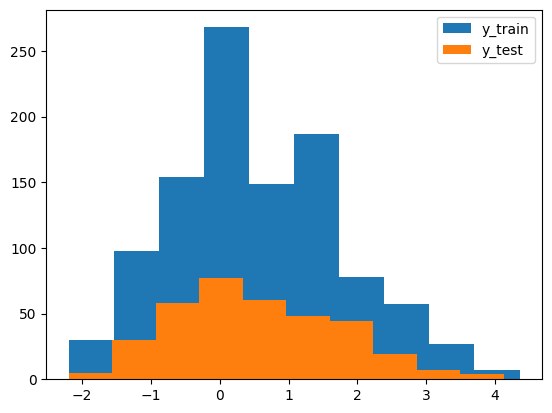

In [56]:
plt.hist(y_train, label='y_train')
plt.hist(y_test, label='y_test')
plt.legend()
plt.show()

In [57]:
# model weights 
model.coef_ 

array([ 1.24851785,  2.20342738,  2.61860551, ..., -1.11450246,
       -2.01824704, -1.06380772])

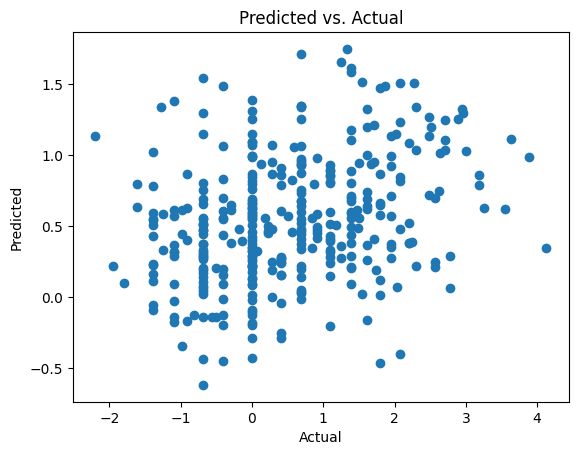

In [58]:
# plot predicted vs. actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual')
plt.show()

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0., 13.,
         0.,  3.,  0.,  0., 11.,  0.,  3.,  4.,  1.,  0., 35.,  0.,  1.,
         2.,  0., 15.,  0.,  3.,  1.,  1.,  0., 59.,  1.,  1.,  1.,  3.,
         7.,  0., 14.,  1.,  2.,  1., 33.,  0.,  0.,  3.,  6.,  0.,  0.,
        18.,  1.,  3.,  1., 19.,  1.,  3.,  2., 10.,  4.,  1.,  8.,  1.,
         8.,  2.,  6.,  0.,  4.,  2.,  3.,  0.,  0.,  4.,  3.,  2.,  3.,
         2.,  0.,  1.,  2.,  1.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-2.19722457, -2.13398098, -2.07073739, -2.0074938 , -1.94425021,
        -1.88100662, -1.81776303, -1.75451944, -1.69127585, -1.62803226,
        -1.56478867, -1.50154508, -1.43830149, -1.3750579 , -1.31181431,
        -1.24857073, -1.18532714, -1.12208355, -1.05883996, -0.99559637,
        -0.93235278, -0.86910919, -0.8058656 , -0.74262201, -0.67937842,
        -0.61613483, -0.55289124, -0.48964765, -0.42640406, -0.363160

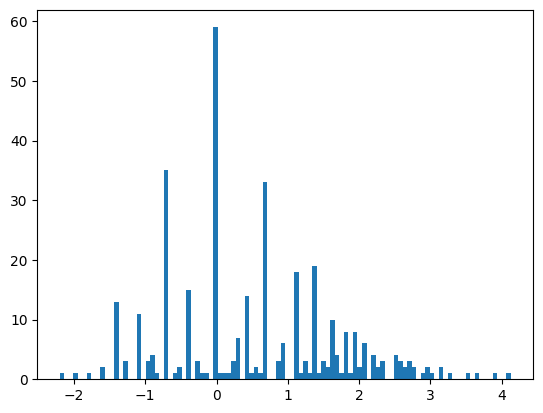

In [49]:
plt.hist(y_test, bins=100)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,  1.,  0.,
         0.,  2.,  1.,  0.,  3.,  3.,  1.,  7.,  1.,  2.,  1.,  2.,  3.,
         3.,  5.,  3.,  3.,  7.,  3.,  6.,  3.,  8., 10.,  7.,  7., 10.,
         7.,  7.,  9.,  8.,  6.,  7.,  7.,  9.,  9.,  2., 13.,  8., 13.,
         7.,  7.,  6.,  6.,  3.,  4.,  2.,  7.,  6.,  3.,  9.,  3.,  1.,
         6.,  5.,  4.,  4.,  5.,  1.,  4.,  5.,  1.,  6.,  0.,  3.,  1.,
         2.,  4.,  2.,  1.,  6.,  1.,  2.,  0.,  0.,  0.,  2.,  3.,  1.,
         1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.]),
 array([-6.16005421e-01, -5.92360079e-01, -5.68714738e-01, -5.45069396e-01,
        -5.21424055e-01, -4.97778714e-01, -4.74133372e-01, -4.50488061e-01,
        -4.26842719e-01, -4.03197378e-01, -3.79552037e-01, -3.55906695e-01,
        -3.32261354e-01, -3.08616012e-01, -2.84970671e-01, -2.61325330e-01,
        -2.37680003e-01, -2.14034662e-01, -1.90389320e-01, -1.66743979e-01,
        -1.43098637e-01, -1.19453304e-01, -9.58079621e

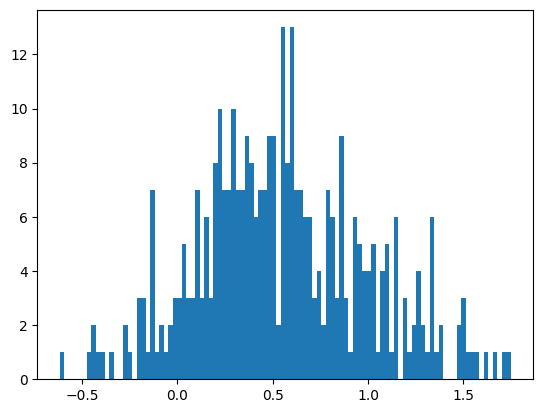

In [48]:
plt.hist(y_pred, bins=100)